<a href="https://colab.research.google.com/github/sebasabarca/cap-comp215/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comp 215 - Project 2 - Deer Park
This cellular automata program simulates a grassland with a population of deers. The deers move randomly each step and in case they encounter a cell with grass, they eat and increase their weight energy. Each time they move, their energy goes down by one and each time they eat, they increse it until the maximum energy level. The grass grows at a certain rate after being eated. The pourpose is to find out if this is a self regulating system that reaches a kind of equilibrium.

Author:  Sebastian  Abarca  

Date:  04/08/24

In [1]:
%matplotlib inline

import time
from pprint import pprint
from timeit import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
Some useful, re-usable bits of code developed in class

In [2]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step(1)
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Deer Class
The best way to tackle this problem is to define each deer as a class object. We can define its position by x and y values, its weight index and define the actions he can do. We are going to create 3 functions. The first one moves the deer to a random subjacent cell, this means each deer can move one cell at a time. The second one checks if the deer has any energy left, this is going to help later to kill the deer in case he has no more energy. The last one, is the eat function which increases the weight index of the deer.

In [4]:
class Deer:
  def __init__(self, weight_index, n, x=None, y=None):
    self.weight_index = weight_index
    self.x = x or np.random.randint(0, n)
    self.y = y or np.random.randint(0, n)

  def random_walk(self, max_values):
      """It generates a random adjacent cordinate for the deer to move. It also reduces by one its weight index."""
      self.weight_index -= 1 # Reduce the stamina
      dx, dy = np.random.randint(-1, 2, size=2) # get the random cordinates between -1 and 1
      new_x = np.clip(self.x + dx, 0, max_values[0] - 1) # change the x value - Chat gpt explained me the clip function
      new_y = np.clip(self.y + dy, 0, max_values[1] - 1) # change the y value
      self.x = new_x # set the new x value
      self.y = new_y # set the new y value


  def any_energy_left(self):
    """This funtion checks if the deer has any energy left"""
    return self.weight_index > 0

  def eat(self):
    """This function increases the weight index by two simulating the process of energy gained."""
    self.weight_index += 2

### Grassland Class
Now that we have our deers define, we have to create their habitat. To create this environment we are going to use another class object. This class is going to simulate each step by growing the cells that have been eaten, move the deers and make them eat in case they find any food they can eat. Also checks if the deers reach energy level of 0 and removes them in case this is true. The other three functions return information of the deer population, the average energy of the deers and the percentage of grass occupied.

In [13]:
class Grassland:

  EATABLE_GRASS = 1
  SOIL = 0
  tolerance = 1e-6

  cmap = [(1, 0.5, 0), (0, 1, 0)]
  cmap[SOIL] = (1, 0.5, 0)  # brown
  cmap[EATABLE_GRASS] = (0, 1, 0)  # green
  forest_colour_map = matplotlib.colors.ListedColormap(cmap)

  def __init__(self, n=10, grow_rate=.25, weight_index=10, max_energy=10, number_of_deers=5):
    self.grow_rate = grow_rate
    self.state = np.ones((n, n), dtype=float)
    self.deers = [Deer(weight_index, n) for _ in range(number_of_deers)] # Creates the deer objects
    self.max_energy = max_energy
    self.cells = n**2

  def step(self, steps=1):
    """Executes one time step, applying the CA rules to move the deers, make them eat or remove them in case they die and grow the grass after being eaten."""
    self.state += self.grow_rate # Grow the grass cells
    for _ in range(steps):
      for d in self.deers:
        if self.state[d.x, d.y] >= self.EATABLE_GRASS: # Check if there's any eatable grass
            if d.weight_index < self.max_energy: # Limit the deers tha have full stamina
              d.eat() # Make the deer eat
              self.state[d.x, d.y] = self.SOIL # Update the state cell to an SOIL cell

        if not d.any_energy_left(): # Check if the deer has no more energy
            self.deers.remove(d) # Remove the deer

      for d in self.deers:
        d.random_walk(max_values=(self.state.shape[0], self.state.shape[1])) # Move the deers to a random position

  def deer_population(self):
    """Returns the number of deers that are alive"""
    return len(self.deers)

  def average_energy(self):
    """Returns the average energy among the deers"""
    return sum([d.weight_index for d in self.deers]) / len(self.deers)

  def grass_occupied(self):
    """Returns the proportion of grass cells"""
    return ((np.count_nonzero(self.state >= self.EATABLE_GRASS)) / self.cells)


  def draw(self, axes=None, step=''):
    """Draws the CA cells using the grass colour map so values are coloured intuitively and shows the deer with their respective weight index.
       Chat gpt helped me add the deers and their energy level"""
    axes = axes or plt.gca()
    title = f'Time:{step} deers:{self.deer_population()}'
    plot_2d_array(self.state, axes=axes, title=title,
    cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
    for deer in self.deers:
        # Determine color based on energy level
        energy_color = plt.cm.RdYlGn(deer.weight_index / 10.0)  # Assuming weight_index ranges from 0 to 10

        # Plot deer position with energy-based color
        axes.plot(deer.y, deer.x, color=energy_color, marker='o', markersize=8)

        # Annotate deer position with weight index
        axes.text(deer.y, deer.x, str(deer.weight_index), color='black', ha='center', va='center')



### Simulation
Let's vizualize a simulation

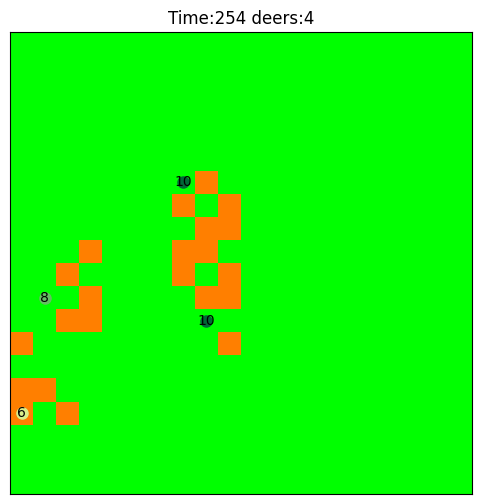

In [10]:
grass_model = Grassland(20,.1, 10, 10, 20)
animation_model = Animation2D(grass_model, frames=100, figsize=(6, 6))
animation_model.animate(.1)

### Functions for the experiment
We need a way to look at the data in a more visual way. It's difficult to perceive the pattern or the equilibrium, if any, by looking at the simulation. We are going to create two functions. One of the plots the percentage of grass ocupied and the other the population of deers each time step.


In [7]:
def grass_equilibrium_plot(grow_rate, weight_index, max_energy, deers):
  """Makes a plot with x = time steps and y = cells ocupied by grass"""
  g =  Grassland(20, grow_rate, weight_index, max_energy, deers)
  x_values = [0]
  y_values = [g.grass_occupied()]
  for i in range(1, 500):
    g.step(1)
    x_values.append(i)
    y_values.append(g.grass_occupied())

  plt.plot(x_values, y_values)
  plt.xlabel('Time Step')
  plt.ylabel('Proportion of Grass Occupied')
  plt.title('Equilibrium Plot for Grass Model')
  plt.show()

def deer_equilibrium_plot(grow_rate, weight_index, max_energy, deers):
  """Makes a plot with x = time steps and y = deer population"""
  g =  Grassland(20, grow_rate, weight_index, max_energy, deers)
  x_values = [0]
  y_values = [g.deer_population()]
  for i in range(1, 500):
    g.step(1)
    x_values.append(i)
    y_values.append(g.deer_population())

  plt.plot(x_values, y_values)
  plt.xlabel('Time Step')
  plt.ylabel('Deer population')
  plt.title('Equilibrium Plot for Number of deers')
  plt.show()

### Graphs
Let's visualize the data

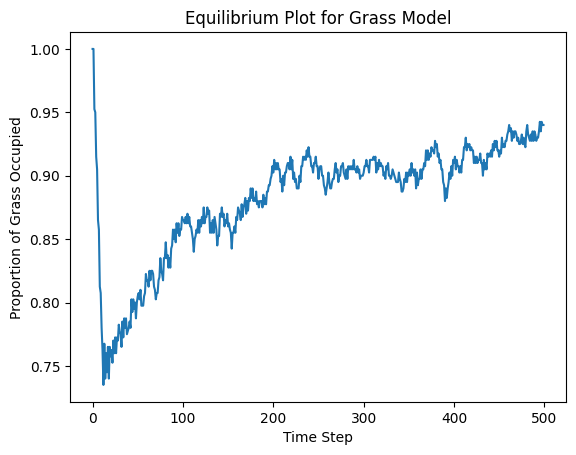

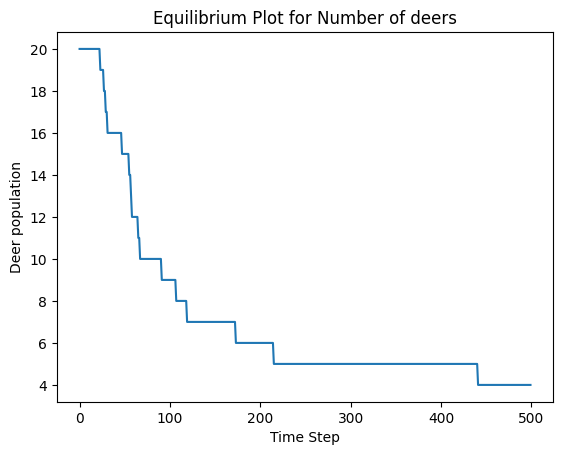

In [14]:
grass_equilibrium_plot(.1, 10, 10, 20)
deer_equilibrium_plot(.1, 10, 10, 20)

### Data summary


| Grow rate  |  Deer population  | steady-state | time steps | Cyclical? ||Deers remaining|
|----|-----|--------------|------------|-----------||-----------|
| 0.05 | 20 | .95 +- .02     | 100         | yes       | |1-2|
| 0.1  | 20   | .95 +- .03   | 300         | yes         ||4-6|
| 0.15  | 20   | .86 +- .025            | 10          | yes         ||5-18|
| 0.20  | 20   | .8 +- .02            | 10          | yes         | |14-19|
| 0.25  |  20   | .90 +- .02            | 10          | yes         | |18-20|
| 0.30  | 20   | .91 +- .01            | 5          | yes         | |18-20|
| 0.35  | 20   | .92 +- .02            | 5          | yes         | |19-20|
| 0.40  | 20   | .93 +- .02            | 5          | yes         | |20|
| 0.45  | 20   | .93 +- .02            | 15          | yes         | |20|
| 0.50  | 20   | .97 +- .03            | 15          | yes         | |20|

### Time to run 100 steps given a grid size and the number of deers

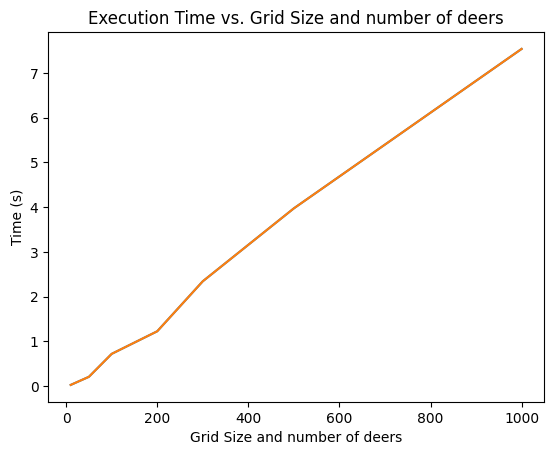

In [16]:
grid_sizes = ((10, 10), (50,50), (100, 100), (200, 200), (300, 300), (500, 500), (1000, 1000))

timings = [
    timeit(lambda: Grassland(grid, 0.1, 10, 10, deers).step(steps=100), number=3)
    for grid, deers in grid_sizes
]

plt.plot(grid_sizes, timings)
plt.xlabel('Grid Size and number of deers')
plt.ylabel('Time (s)')
plt.title('Execution Time vs. Grid Size and Number of Deers')
plt.show()

### Conclusions
We can identify a bell shape patter from the steady states with the different growth rates of the grass. With small grow rates we see a high steady state because the deer are not able to survive with the available food and therefore they die. Then, when the growth reaches .25, the occupied grass cell's steady state starts increasing and the deer population begins to remain the same. There's food to maintain a population of 20 deer, and the equilibrium state is reached. This project is fascinating because it tells us a lot about the real world. A simple system where organisms eat the available food and require it to grow at an equilibrium rate to secure survival can be escalated to the human population and how fast should we generate food. There's the possibility to add function that reproduce the deer or even to kill a deer at random, simulating eminent death. It was a challenging project, but I definitely learned a lot from it.